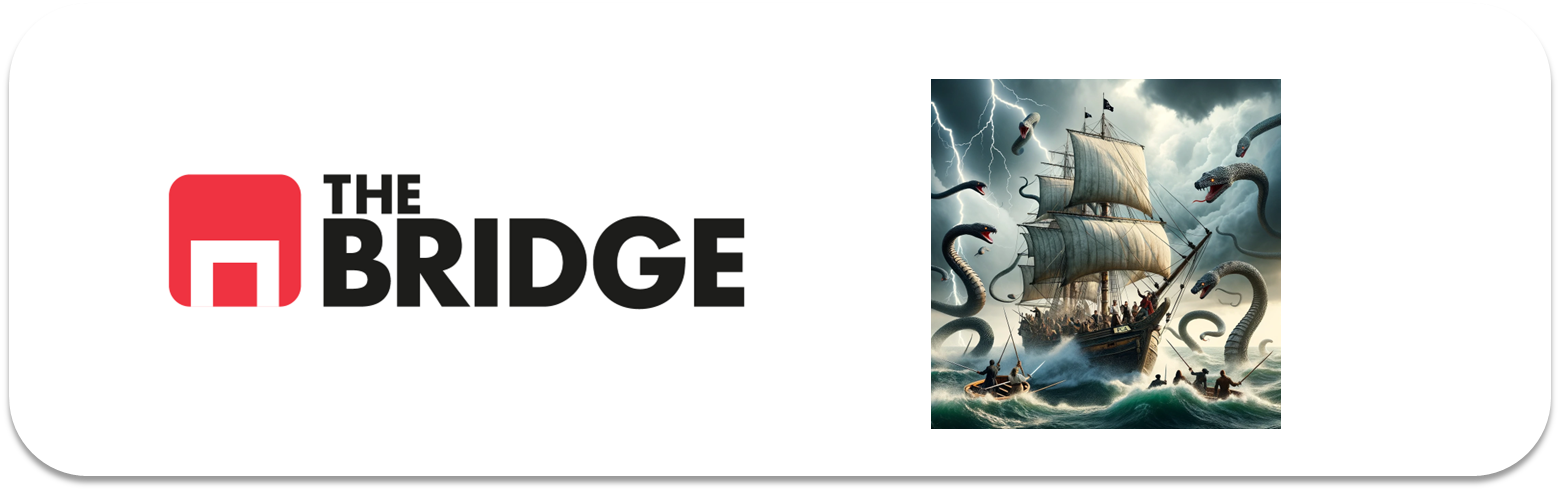

## PRACTICA OBLIGATORIA: **Seleccion Features**

* La práctica obligatoria de esta unidad consiste en hacer una comparativa de diferentes técnicas de selección de features sobre un dataset ya conocido. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Descripción General y Objetivo

El objetivo de la práctica es que juegues con las diferentes técncias de selección de features sobre un problema de clasificación. Para ello, tendrás que cargar el dataset de credit scoring que tienes en la carpeta "data" y que ya hemos trabajado anteriormente. A partir de ahí tendrás que probar diferentes técnicas de selección de features y compararlas todas entre sí y escoger finalmente el conjunto más sencillo con más potencia. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [26]:
import bootcampviztools as bt
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from collections import Counter
from lightgbm import LGBMClassifier
from scipy.stats import mannwhitneyu
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif, SelectFromModel, RFE, SequentialFeatureSelector
from sklearn.metrics import mutual_info_score, classification_report
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from xgboost import XGBClassifier

### Detalles e Instrucciones

El objetivo es que construyas un modelo final de clasificació sobre la variable "SeriousDlqin2yrs" del dataset que encontrarás en "data".  

Sigue los pasos del proceso de ML que hemos aprendido para problemas supervisados con el dataset que encontrarás en "data" pero con las siguiente salvedades:

1. Deshazte de las filas con nulos, para este ejercicio no nos importan. Convierte las features NumberOf... que creas conveniente a categóricas con 2 o 3 niveles a lo sumo.

2. A la hora de hacer el miniEda aplica los siguientes análisis y selección de features: 
    1. Análisis visual combinado con filtrado por valores de correlación y umbral de covarianza.
    2. Selección de features numéricas mediante SelectKBest y ANOVA, selecció de features categóricas mediante Mutual Information 
    3. Selección de las mejores features a través de un modelo intermedio (usando SelectFromModel)
    4. Selección de las mejores features empleando RFE.
    5. Selección de las mejores features empleando SFS.
    6. Selección de las mejores features mediante un sistema de hard-voting aplicado a lo obtenido en los pasos 1 a 5 anteriores.

    Para cada paso anterior (salvo el 1) se pide obtener una lista de features de "primera división" con un número de variables no superior a 6 (pueden ser menos).

3. Escoge tres modelos y a la hora compararlos para escoger el mejor, entrenalos con validación cruzada empleando las seis listas obtenidas anteriormente. Es decir tendrás 18 (6*3) medidas (emplea la métrica que creas más conveniente y si no se te ocurre ninguna el recall medio).  Escoge el mejor modelo y la mejor selección de features.

4. Optimiza los hiperparámetros del mejor modelo. Evalúalo contra test.


Cargar Dataset y visualizacion

In [27]:
df = pd.read_csv('./data/credit_npo.csv')

In [28]:
df.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,0,0.081892,37,0,0.070709,5656.0,12,1,0,0,0.0
1,0,0.023413,74,0,0.209197,4870.0,9,0,1,0,0.0
2,0,0.000000,43,0,0.080784,5000.0,2,0,0,0,2.0
3,0,0.492754,44,0,0.412735,7333.0,4,0,2,0,3.0
4,0,1.000000,63,0,0.000000,8333.0,3,0,0,0,1.0


In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12537 entries, 0 to 12536
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   SeriousDlqin2yrs                      12537 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  12537 non-null  float64
 2   age                                   12537 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  12537 non-null  int64  
 4   DebtRatio                             12537 non-null  float64
 5   MonthlyIncome                         11816 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       12537 non-null  int64  
 7   NumberOfTimes90DaysLate               12537 non-null  int64  
 8   NumberRealEstateLoansOrLines          12537 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  12537 non-null  int64  
 10  NumberOfDependents                    12360 non-null  float64
dtypes: float64(4), 

Nulos y Conversion features

In [30]:
df_sin_nulos = df.dropna()
df_sin_nulos.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11816 entries, 0 to 12536
Data columns (total 11 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   SeriousDlqin2yrs                      11816 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  11816 non-null  float64
 2   age                                   11816 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  11816 non-null  int64  
 4   DebtRatio                             11816 non-null  float64
 5   MonthlyIncome                         11816 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       11816 non-null  int64  
 7   NumberOfTimes90DaysLate               11816 non-null  int64  
 8   NumberRealEstateLoansOrLines          11816 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  11816 non-null  int64  
 10  NumberOfDependents                    11816 non-null  float64
dtypes: float64(4), int64

In [31]:
df = df_sin_nulos

In [32]:
def discretize_into_three_categories(series):
    bins = [series.min(), series.quantile(0.33), series.quantile(0.66), series.max()]
    labels = ["Low", "Medium", "High"]
    unique_bins = sorted(set(bins))
    return pd.cut(series, bins=unique_bins, labels=labels[:len(unique_bins)-1], include_lowest=True)

In [33]:
columns_to_convert = [
    'NumberOfTime30-59DaysPastDueNotWorse',
    'NumberOfOpenCreditLinesAndLoans',
    'NumberOfTimes90DaysLate',
    'NumberRealEstateLoansOrLines',
    'NumberOfTime60-89DaysPastDueNotWorse',
    'NumberOfDependents'
]

for column in columns_to_convert:
    df[column] = discretize_into_three_categories(df[column].astype(float))

In [34]:
df.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,0,0.081892,37,Low,0.070709,5656.0,High,Low,Low,Low,Low
1,0,0.023413,74,Low,0.209197,4870.0,Medium,Low,Low,Low,Low
2,0,0.000000,43,Low,0.080784,5000.0,Low,Low,Low,Low,Medium
3,0,0.492754,44,Low,0.412735,7333.0,Low,Low,Medium,Low,Medium
4,0,1.000000,63,Low,0.000000,8333.0,Low,Low,Low,Low,Low


In [35]:
cat_col = columns_to_convert

In [36]:
target = 'SeriousDlqin2yrs'

In [37]:
train_set, test_set = train_test_split(df, test_size = 0.2, random_state = 42)

MiniEDA

<Axes: xlabel='SeriousDlqin2yrs', ylabel='count'>

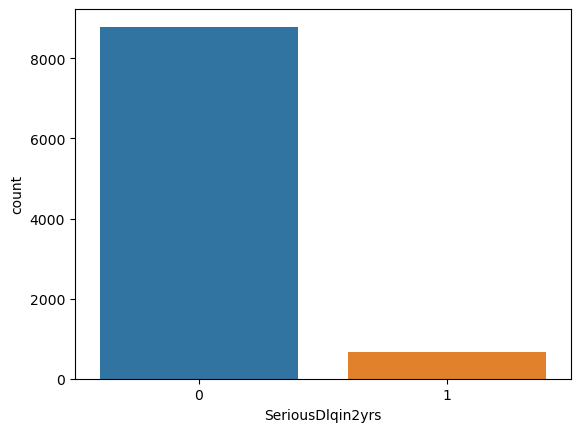

In [38]:
# 1. Análisis visual combinado con filtrado por valores de correlación y umbral de covarianza
sns.countplot(data=train_set, x=target)

Gráfico entre SeriousDlqin2yrs y NumberOfTime30-59DaysPastDueNotWorse


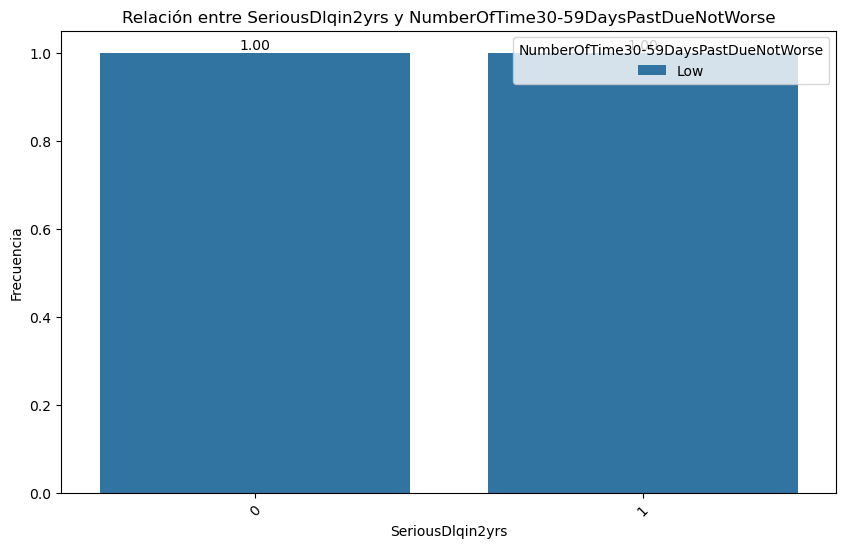

Gráfico entre SeriousDlqin2yrs y NumberOfOpenCreditLinesAndLoans


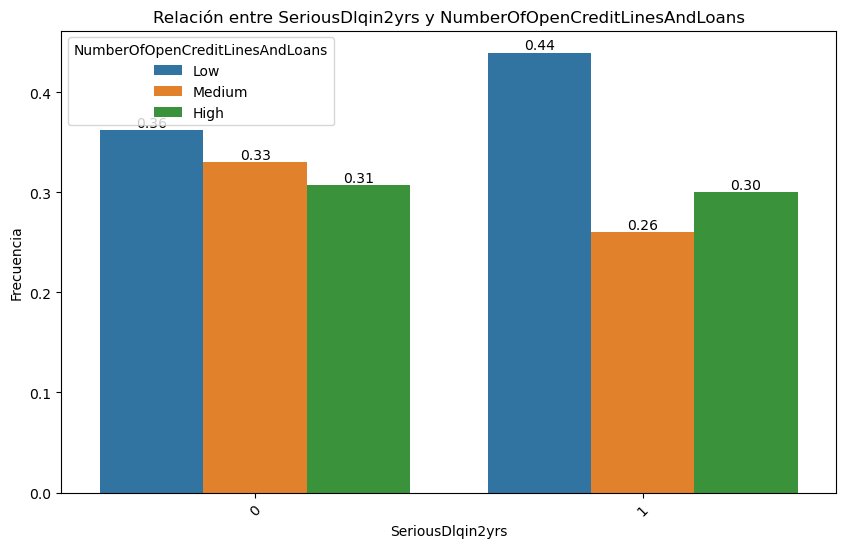

Gráfico entre SeriousDlqin2yrs y NumberOfTimes90DaysLate


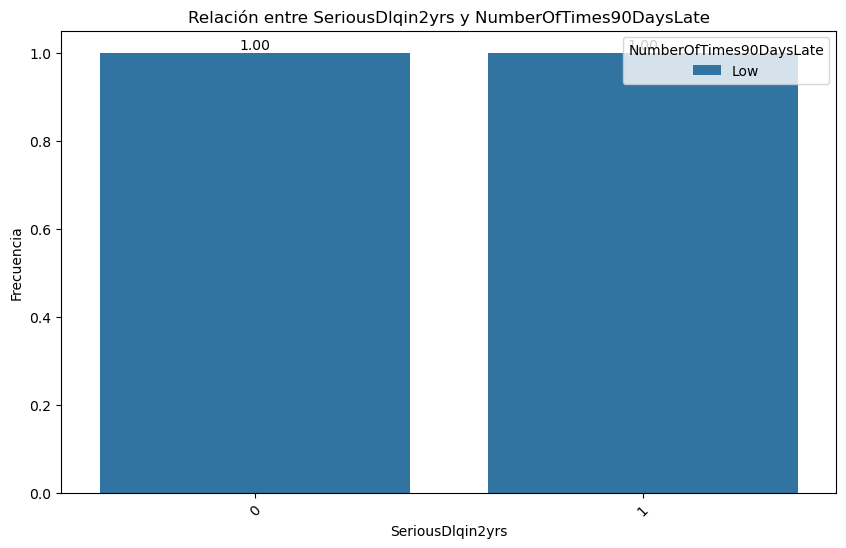

Gráfico entre SeriousDlqin2yrs y NumberRealEstateLoansOrLines


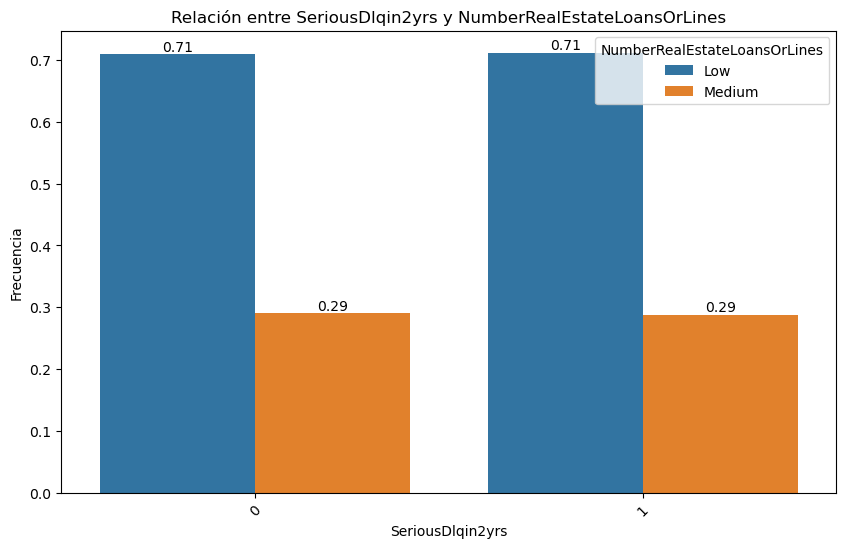

Gráfico entre SeriousDlqin2yrs y NumberOfTime60-89DaysPastDueNotWorse


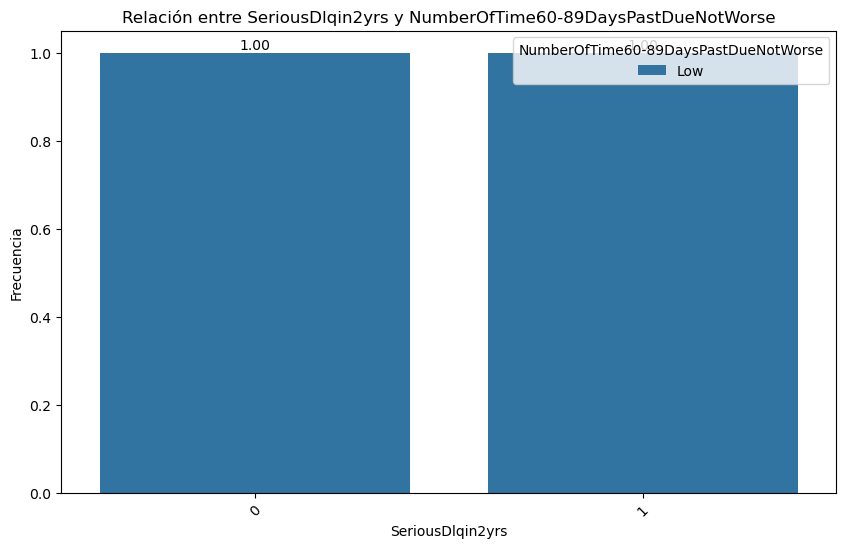

Gráfico entre SeriousDlqin2yrs y NumberOfDependents


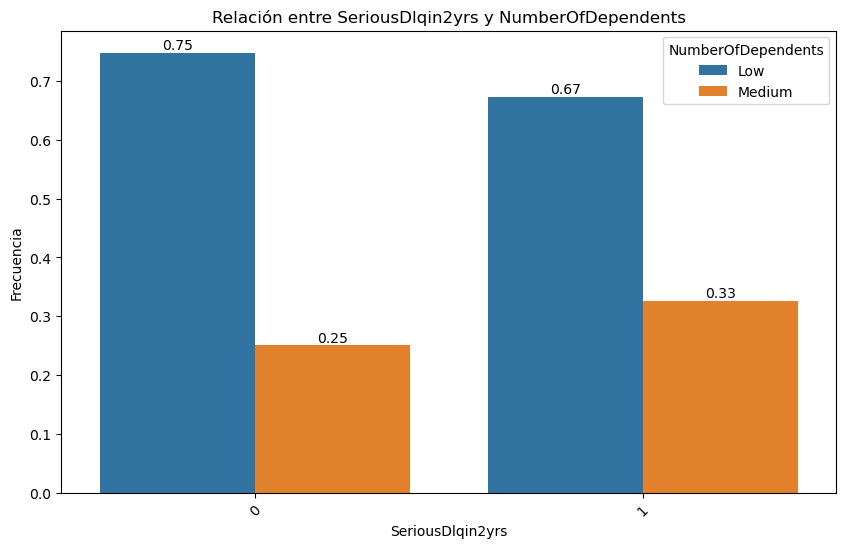

In [39]:
for column in cat_col:
    print(f"Gráfico entre {target} y {column}")
    bt.plot_categorical_relationship_fin(df, target, column, relative_freq=True, show_values=True, size_group=5)

In [40]:
data_dummies = pd.get_dummies(df, columns = cat_col, drop_first=True)

In [41]:
# Calcular la matriz de correlación y covarianza
correlation_matrix = data_dummies.corr()
covariance_matrix = data_dummies.cov()

In [42]:
correlation_threshold = 0.3
filtered_correlations = correlation_matrix[(correlation_matrix >= correlation_threshold) | (correlation_matrix <= -correlation_threshold)]

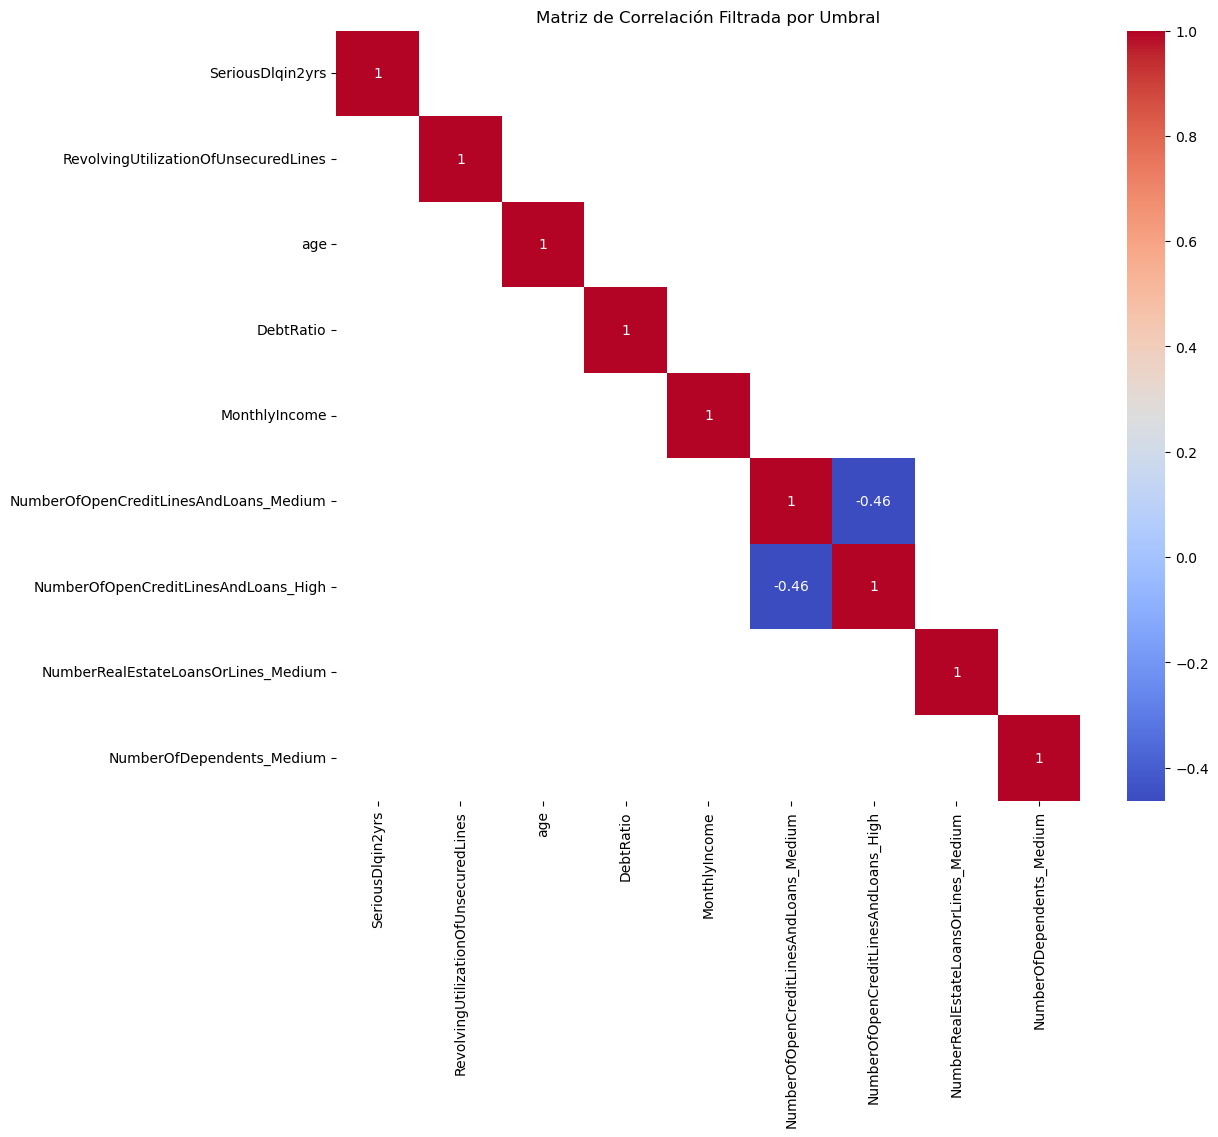

In [43]:
plt.figure(figsize=(12, 10))
sns.heatmap(filtered_correlations, annot=True, cmap='coolwarm', cbar=True, mask=filtered_correlations.isnull())
plt.title('Matriz de Correlación Filtrada por Umbral')
plt.show()

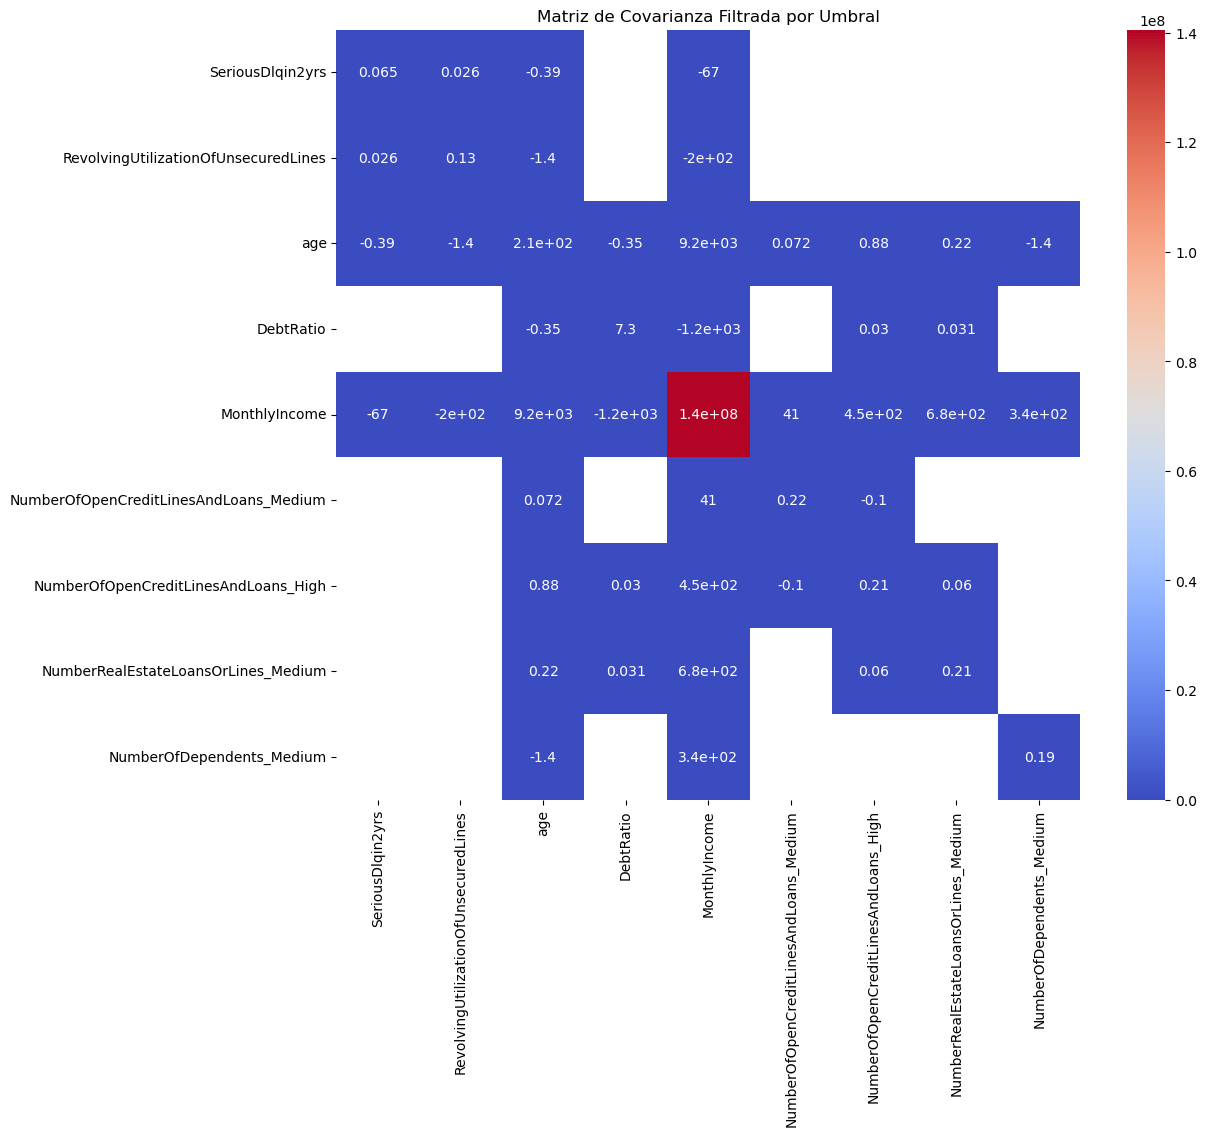

In [44]:
covariance_threshold = 0.02
filtered_covariance = covariance_matrix[(covariance_matrix >= covariance_threshold) | (covariance_matrix <= -covariance_threshold)]

plt.figure(figsize=(12, 10))
sns.heatmap(filtered_covariance, annot=True, cmap='coolwarm', cbar=True, mask=filtered_covariance.isnull())
plt.title('Matriz de Covarianza Filtrada por Umbral')
plt.show()

In [45]:
# 2. Selección de features numéricas mediante SelectKBest y ANOVA, selecció de features categóricas mediante Mutual Information 
from scipy import stats

cat_col_array = np.array(cat_col)
f_val, p_val = stats.f_oneway(*cat_col_array)

print("Valor F:", f_val)
print("Valor p:", p_val)

ValueError: could not convert string to float: 'NumberOfTime30-59DaysPastDueNotWorse'

In [ ]:
cat_col = "quality"
quality_cat = df_wines[cat_col].unique()  # Obtener los valores únicos de la columna categórica, en este caso la compañía área
alcohol_por_quality = [df_wines[df_wines[cat_col] == categoria]['alcohol'] for categoria in quality_cat] # obtenemos los ingresos por compañía y los incluimos en una lista

### EXTRA

Aplica la PCA como método de selección, escoge un número de componentes en función de la varianza explicada y crea un dataset con el que entrenar el mismo tipo de modelo ganador de la parte general. Entrenalo y evalúalo contra test, comenta el resultado.